In [ ]:
import pandas as pd
import pandas_datareader as web
import numpy as np
import datetime as dt

import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.stattools import adfuller

import seaborn as sns
import matplotlib.pyplot as plt

# Objetivo
Teste de estratégia de long-short por cointegração e backtesting.

In [ ]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (15,5)
sns.set()

In [ ]:
def z_score(serie):
  return (serie - serie.mean())/np.std(serie)

In [ ]:
def cointtest(Y,X):
  Spread = Y - X 
  score,pvalue, _ = coint(Y,X)
  Reg = sm.OLS(Y,X)
  Reg = Reg.fit()
  RegResids = Reg.resid
  adf = adfuller(Reg.resid)
  RegResidsZ = z_score(Reg.resid)
  _ = (plt.plot(RegResidsZ, label = 'Valor Z'),
          plt.title('Valor Z dos Resíduos {} x {}'.format(Y.name,X.name),fontsize = 15),
          plt.axhline(1,color='red',linestyle='--',label='1 Desvio Padrão'),
          plt.axhline(-1,color='black',linestyle='--',label = '- 1 Desvio Padrão'),
          plt.legend(fontsize = 12))
  print('Engle-Granger p-valor:',pvalue)
  print('Beta:',Reg .params[0])
  print('ADF p-valor: ',adf[1])
  print('ADF Valor Crítico: ',adf[0])
  print('Threshold ADF:',adf[4])

In [ ]:
Start = '2012-01-10'
End = '2020-01-10'

In [ ]:
indices = ('BOVA11.SA','SMAL11.SA')

In [ ]:
Indices = web.DataReader(indices,'yahoo',Start,End)['Adj Close']

In [ ]:
tickers = ('WEGE3.SA','ITSA4.SA','VVAR3.SA','MRFG3.SA','PETR4.SA')

In [ ]:
Ibov = web.DataReader('^BVSP','yahoo',Start,End)['Adj Close']

In [ ]:
Carteira = web.DataReader(tickers,'yahoo',Start,End)['Adj Close']

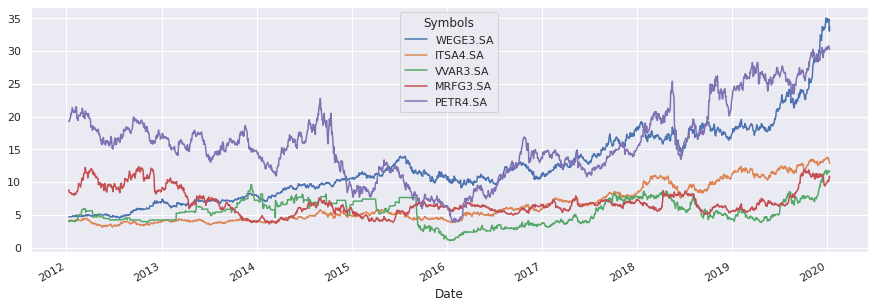

In [ ]:
Carteira.plot();

### Backtest Trade Tesla x Toyota:

In [ ]:
TSLA_TM = web.DataReader(('TSLA','TM'),'yahoo',Start,End)['Adj Close']

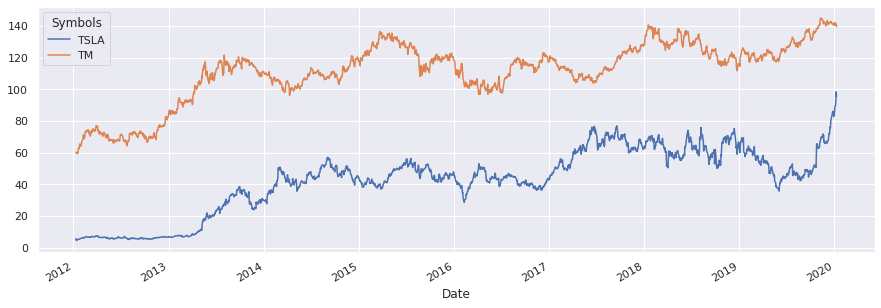

In [ ]:
TSLA_TM.plot();

In [ ]:
Reg = sm.OLS(TSLA_TM['TM'],TSLA_TM['TSLA'])
Reg = Reg.fit()
RegResid = Reg.resid
RegResidZ = z_score(RegResid)

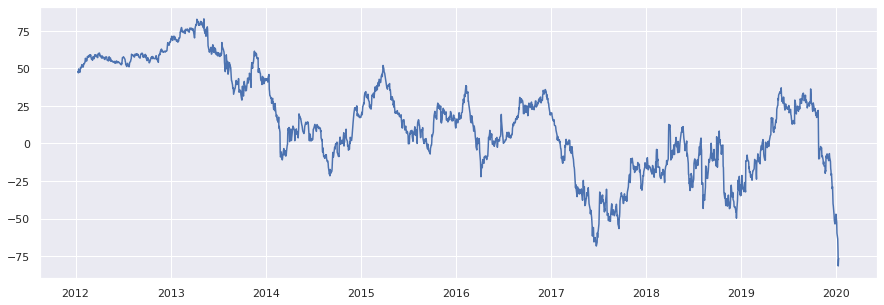

In [ ]:
plt.plot(Reg.resid)

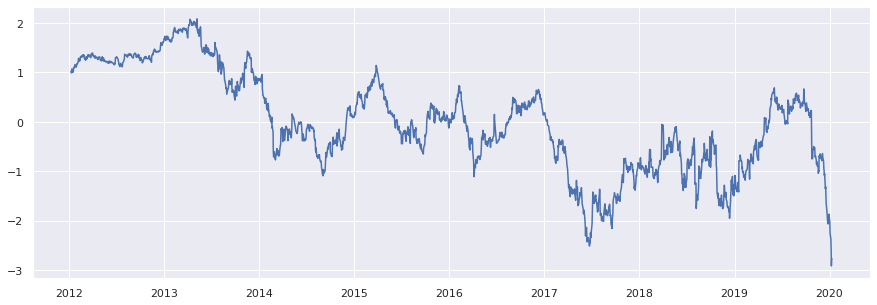

In [ ]:
plt.plot(z_score(Reg.resid))

In [ ]:
print(Reg.summary())

                                 OLS Regression Results                                
Dep. Variable:                     TM   R-squared (uncentered):                   0.899
Model:                            OLS   Adj. R-squared (uncentered):              0.899
Method:                 Least Squares   F-statistic:                          1.791e+04
Date:                Sat, 09 Jan 2021   Prob (F-statistic):                        0.00
Time:                        23:39:02   Log-Likelihood:                         -10071.
No. Observations:                2014   AIC:                                  2.014e+04
Df Residuals:                    2013   BIC:                                  2.015e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Engle-Granger p-valor: 0.06564460007846722
Beta: 2.263407543605147
ADF p-valor:  0.5915085307884562
ADF Valor Crítico:  -1.3806673777987213
Threshold ADF: {'1%': -3.4336026867364144, '5%': -2.8629768669694458, '10%': -2.5675349256978177}


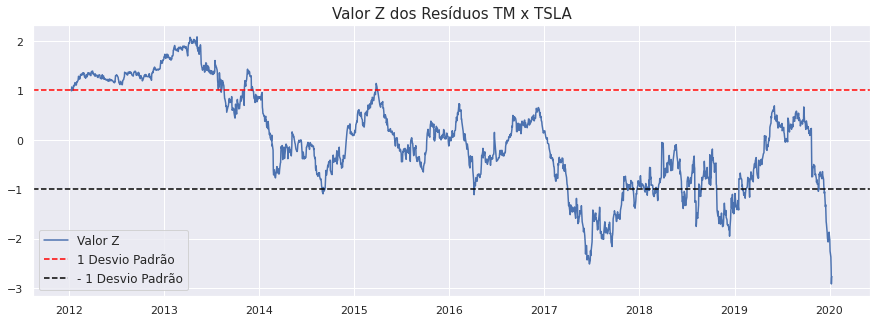

In [ ]:
cointtest(TSLA_TM['TM'],TSLA_TM['TSLA'])

In [ ]:
TSLA_TM['Retorno TSLA'] = TSLA_TM['TSLA'].pct_change() 
TSLA_TM['Retorno TM'] = TSLA_TM['TM'].pct_change() 

In [ ]:
TSLA_TM['Retorno'] = TSLA_TM['Retorno TM'] + TSLA_TM['Retorno TSLA']

In [ ]:
TSLA_TM['Alvo TSLA'] = TSLA_TM['Retorno TSLA'].shift(-1)
TSLA_TM['Alvo TM'] = TSLA_TM['Retorno TM'].shift(-1)

In [ ]:
Trade = []
Short_Spread = []
Long_Spread = []
for day in range(len(Reg.resid)):
  if z_score(Reg.resid).iloc[day] > 1:
    trade = Reg.params[0]*TSLA_TM['Alvo TSLA'].iloc[day] + -1*TSLA_TM['Alvo TM'].iloc[day]
    Short_Spread.append(trade)
  elif z_score(Reg.resid).iloc[day] < -1:
    trade = -Reg.params[0]*TSLA_TM['Alvo TSLA'].iloc[day] + 1*TSLA_TM['Alvo TM'].iloc[day]
    Long_Spread.append(trade)
  else:
    trade = TSLA_TM['Retorno'].iloc[day]
  Trade.append(trade)

In [ ]:
TSLA_TM['Reg Z'] = z_score(Reg.resid)

In [ ]:
TSLA_TM['Trade'] = Trade
TSLA_TM['Trade Acc'] = TSLA_TM['Trade'].cumsum()

In [ ]:
TSLA_TM['Retorno TM'] + TSLA_TM['Retorno TSLA']

Date
2012-01-10         NaN
2012-01-11    0.021066
2012-01-12   -0.005997
2012-01-13   -0.191513
2012-01-17    0.158096
                ...   
2020-01-06    0.019397
2020-01-07    0.044057
2020-01-08    0.046732
2020-01-09   -0.026550
2020-01-10   -0.012179
Length: 2014, dtype: float64

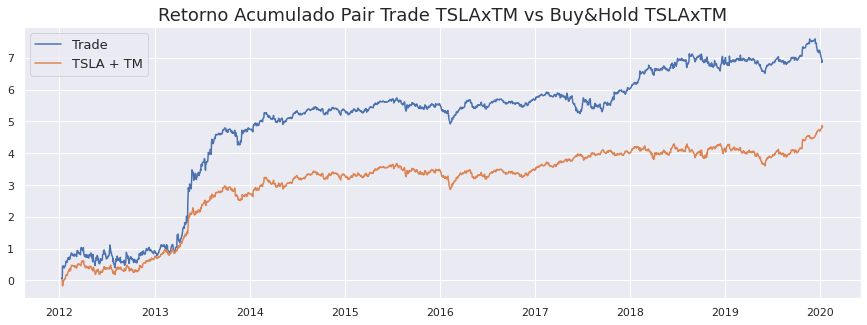

In [ ]:
plt.plot(TSLA_TM['Trade Acc'],label='Trade')
plt.plot(TSLA_TM['Retorno'].cumsum(),label='TSLA + TM')
plt.title('Retorno Acumulado Pair Trade TSLAxTM vs Buy&Hold TSLAxTM',fontsize=18)
plt.legend(fontsize=13,loc='upper left')
plt.show()

### Backtest Trade JPM x BofA:

In [ ]:
JPM_BAC = web.DataReader(('JPM','BAC'),data_source='yahoo',start=Start,end=End)['Adj Close']

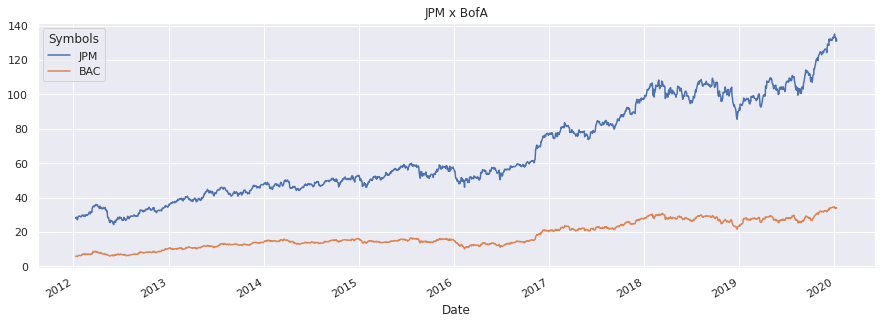

In [ ]:
JPM_BAC.plot(title='JPM x BofA');

Engle-Granger p-valor: 0.15559280971356915
Beta: 0.27018549768145056
ADF p-valor:  0.06081482407347561
ADF Valor Crítico:  -2.7825169217400694
Threshold ADF: {'1%': -3.4336026867364144, '5%': -2.8629768669694458, '10%': -2.5675349256978177}


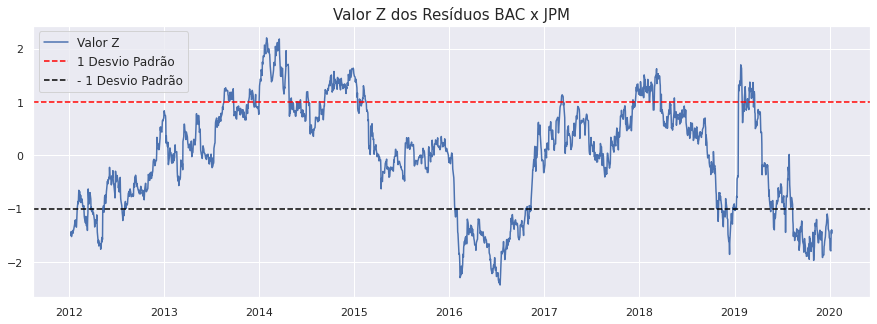

In [ ]:
cointtest(JPM_BAC['BAC'],JPM_BAC['JPM'])

In [ ]:
Reg = sm.OLS(JPM_BAC['BAC'],JPM_BAC['JPM'])
Reg = Reg.fit()
RegResid = Reg.resid
RegResidZ = z_score(RegResid)

In [ ]:
JPM_BAC['Retorno JPM'] = JPM_BAC['JPM'].pct_change() 
JPM_BAC['Retorno BofA'] = JPM_BAC['BAC'].pct_change() 

In [ ]:
JPM_BAC['Retorno'] = JPM_BAC['Retorno JPM'] + JPM_BAC['Retorno BofA']

In [ ]:
JPM_BAC['Alvo JPM'] = JPM_BAC['Retorno JPM'].shift(-1)
JPM_BAC['Alvo BofA'] = JPM_BAC['Retorno BofA'].shift(-1)

In [ ]:
Trade = []
Short_Spread = []
Long_Spread = []
for day in range(len(Reg.resid)):
  if z_score(Reg.resid).iloc[day] > 1:
    trade = Reg.params[0]*JPM_BAC['Alvo JPM'].iloc[day] + -1*JPM_BAC['Alvo BofA'].iloc[day]
    Short_Spread.append(trade)
  elif z_score(Reg.resid).iloc[day] < -1:
    trade = -Reg.params[0]*JPM_BAC['Alvo JPM'].iloc[day] + 1*JPM_BAC['Alvo BofA'].iloc[day]
    Long_Spread.append(trade)
  else:
    trade = JPM_BAC['Retorno'].iloc[day]
  Trade.append(trade)

In [ ]:
JPM_BAC['Reg Z'] = z_score(Reg.resid)

In [ ]:
JPM_BAC['Trade'] = Trade
JPM_BAC['Trade Acc'] = JPM_BAC['Trade'].cumsum()

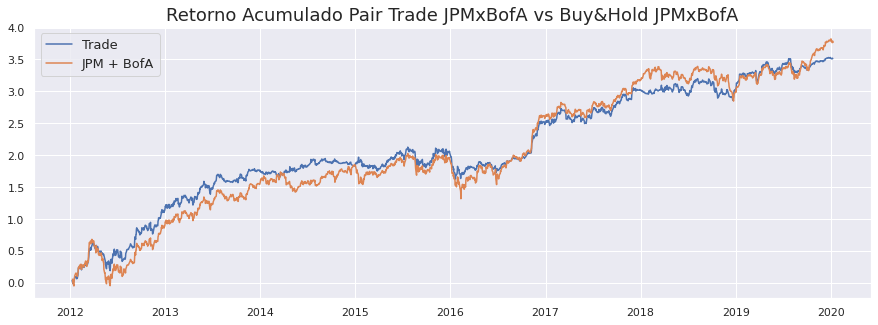

In [ ]:
plt.plot(JPM_BAC['Trade Acc'],label='Trade')
plt.plot(JPM_BAC['Retorno'].cumsum(),label='JPM + BofA')
plt.title('Retorno Acumulado Pair Trade JPMxBofA vs Buy&Hold JPMxBofA',fontsize=18)
plt.legend(fontsize=13,loc='upper left')
plt.show()

In [ ]:
JPM_BAC

### Backtest Trade Facebook x Google:

In [ ]:
FB_GOOGL = web.DataReader(('GOOGL','FB'),'yahoo','2013-01-10',End)['Adj Close']

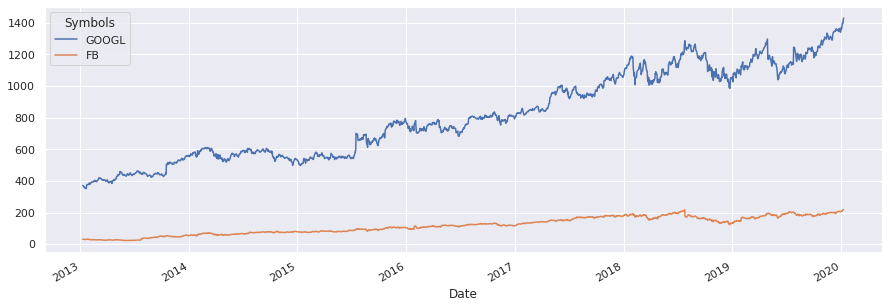

In [ ]:
FB_GOOGL.plot();

In [ ]:
Reg = sm.OLS(FB_GOOGL['FB'],FB_GOOGL['GOOGL'])
Reg = Reg.fit()
RegResid = Reg.resid
RegResidZ = z_score(RegResid)

In [ ]:
Reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     FB   R-squared (uncentered):                   0.981
Model:                            OLS   Adj. R-squared (uncentered):              0.981
Method:                 Least Squares   F-statistic:                          9.184e+04
Date:                Sat, 09 Jan 2021   Prob (F-statistic):                        0.00
Time:                        23:54:32   Log-Likelihood:                         -7570.7
No. Observations:                1763   AIC:                                  1.514e+04
Df Residuals:                    1762   BIC:                                  1.515e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
GOOGL          0.1497      0.000    303.044      0.000       0.149       0.151
==============================================================================
Omnibus:                       39.057   Durbin-Watson:                   0.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.272
Skew:                          -0.139   Prob(JB):                     5.36e-06
Kurtosis:                       2.497   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

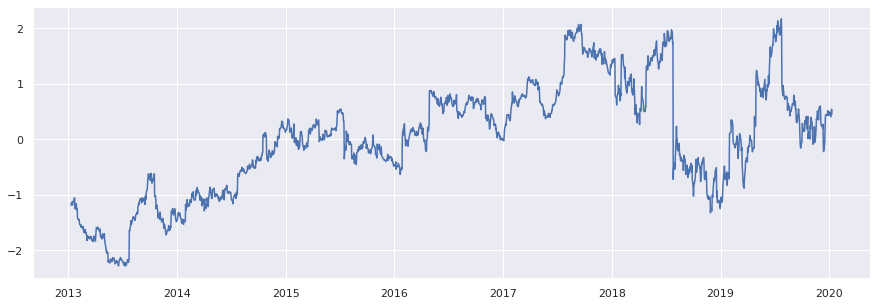

In [ ]:
plt.plot(RegResidZ);

Engle-Granger p-valor: 0.06669598414950273
Beta: 0.14965674651739597
ADF p-valor:  0.1000652599073294
ADF Valor Crítico:  -2.5667530029620966
Threshold ADF: {'1%': -3.4340667152437305, '5%': -2.8631817229557326, '10%': -2.5676440035250416}


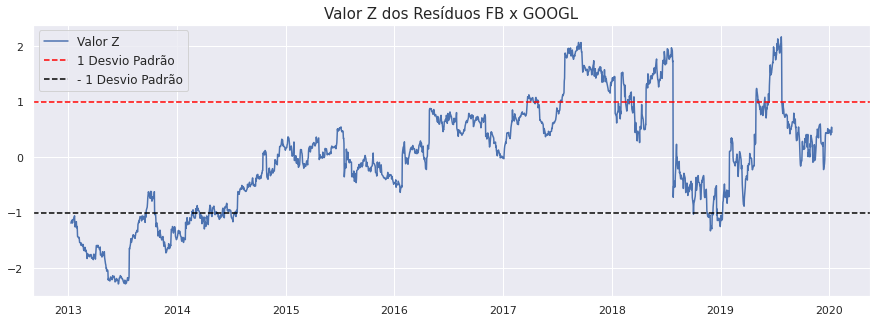

In [ ]:
cointtest(FB_GOOGL['FB'],FB_GOOGL['GOOGL'])

In [ ]:
FB_GOOGL['Retorno FB'] = FB_GOOGL['FB'].pct_change() 
FB_GOOGL['Retorno Google'] = FB_GOOGL['GOOGL'].pct_change() 

In [ ]:
FB_GOOGL['Retorno'] = FB_GOOGL['Retorno FB'] + FB_GOOGL['Retorno Google']

In [ ]:
FB_GOOGL['Alvo FB'] = FB_GOOGL['Retorno FB'].shift(-1)
FB_GOOGL['Alvo Google'] = FB_GOOGL['Retorno Google'].shift(-1)

In [ ]:
Trade = []
Short_Spread = []
Long_Spread = []
for day in range(len(Reg.resid)):
  if z_score(Reg.resid).iloc[day] > 1:
    trade = Reg.params[0]*FB_GOOGL['Alvo Google'].iloc[day] + -1*FB_GOOGL['Alvo FB'].iloc[day]
    Short_Spread.append(trade)
  elif z_score(Reg.resid).iloc[day] < -1:
    trade = -Reg.params[0]*FB_GOOGL['Alvo Google'].iloc[day] + 1*FB_GOOGL['Alvo FB'].iloc[day]
    Long_Spread.append(trade)
  else:
    trade = FB_GOOGL['Retorno'].iloc[day]
  Trade.append(trade)

In [ ]:
FB_GOOGL['Reg Z'] = z_score(Reg.resid)

In [ ]:
FB_GOOGL['Trade'] = Trade
FB_GOOGL['Trade Acc'] = FB_GOOGL['Trade'].cumsum()

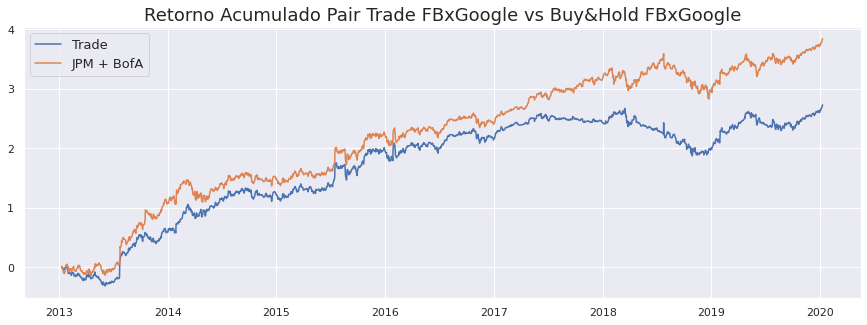

In [ ]:
plt.plot(FB_GOOGL['Trade Acc'],label='Trade')
plt.plot(FB_GOOGL['Retorno'].cumsum(),label='JPM + BofA')
plt.title('Retorno Acumulado Pair Trade FBxGoogle vs Buy&Hold FBxGoogle',fontsize=18)
plt.legend(fontsize=13,loc='upper left')
plt.show()